Import all packages here

In [56]:
import tensorflow as tf
from transformers import Wav2Vec2Processor, TFWav2Vec2Model, Trainer, TrainingArguments

import librosa
from librosa.effects import trim
import librosa.display

from IPython.display import Audio

from sklearn.model_selection import train_test_split

import scipy as sy
import pydub as pyd

import jiwer as jw

import pandas as pd 
import numpy as np 

import os

import matplotlib.pyplot as plt

import re


Mounting Gdrive for the datasets

In [57]:
# Still finding alternatives to access dataset on gdrive without downloading the datasets locally

Setting up the Dataset

In [58]:
dataset_path = "dataset/"
metadata = "dataset.csv"

audio_directory = "dataset/"

# Create a dataframe for the transcript
dataframe = pd.read_csv(metadata)

# Display dataframe to check if ready

print(dataframe.head())

  File_Path Speaker         Transcription Session
0     03M_1     03M  1 2 3 4 5 6 7 8 9 10       1
1     03M_2     03M                   ata       2
2     03M_3     03M                   ana       3
3     03M_4     03M                   ara       4
4     03M_5     03M                  atha       5


Data Pre-Processing

In [59]:
# Preprocess transcript
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # Remove non-alphabetic characters
    return text

dataframe['clean_transcript'] = dataframe['Transcription'].apply(preprocess_text)

print(dataframe['clean_transcript'].head(50))

0                                                 
1                                              ata
2                                              ana
3                                              ara
4                                             atha
5                                              asa
6                                             asha
7                                              ala
8                                              aya
9                                              aka
10                                            acha
11                                            bang
12                                             apa
13                                             ama
14                                             afa
15                                             awa
16                                             iki
17                                             oko
18                                             iti
19                             

In [60]:
Sampling_rate = 16000

# Function to preprocess audio and connect to transcripts
def preprocess_audio_with_transcript(directory, sampling_rate, transcript_df):
    audio_data = []    
     # Iterate over each row in the DataFrame
    for index, row in transcript_df.iterrows():
        file_name = row['File_Path']  # Get the file name from the CSV (without .wav)
        transcript = row['Transcription']  # Get the transcript
        
        # Construct the full file path by combining directory and file name with .wav extension
        file_path = os.path.join(directory, f"{file_name}.wav")
        
        # Check if the file exists in the audio directory
        if os.path.exists(file_path):
            try:
                # Load the audio file
                signal, sr = librosa.load(file_path, sr=sampling_rate)
                
                if len(signal) == 0:
                    print(f"Warning: File {file_path} is empty. Skipping.")
                    continue
                
                # Normalize the audio data
                signal = signal / max(abs(signal))
                
                # Trim silence
                signal, _ = librosa.effects.trim(signal, top_db=20)
                
                # Append the processed data along with the transcript
                audio_data.append({
                    "file_path": file_path,
                    "transcript": transcript,
                    "signal": signal,
                    "sampling_rate": sr
                })
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    
    return audio_data

# Preprocess audio files and connect to transcripts
audio_data_with_transcripts = preprocess_audio_with_transcript(audio_directory, Sampling_rate, dataframe)

# Check if the data is ready
if len(audio_data_with_transcripts) > 0:
    print("Preprocessed audio files with transcripts:")
    for dataset in audio_data_with_transcripts:
        print(f"File: {dataset['file_path']}, Signal Length: {len(dataset['signal'])}, Transcript: {dataset['transcript']}")
else:
    print("No audio files were processed.")


Preprocessed audio files with transcripts:
File: dataset/01F_1.wav, Signal Length: 100352, Transcript: 1 2 3 4 5 6 7 8 9 10
File: dataset/01F_3.wav, Signal Length: 136704, Transcript: ana
File: dataset/01F_4.wav, Signal Length: 137728, Transcript: ara


Visualizing the results of pre-processed audio

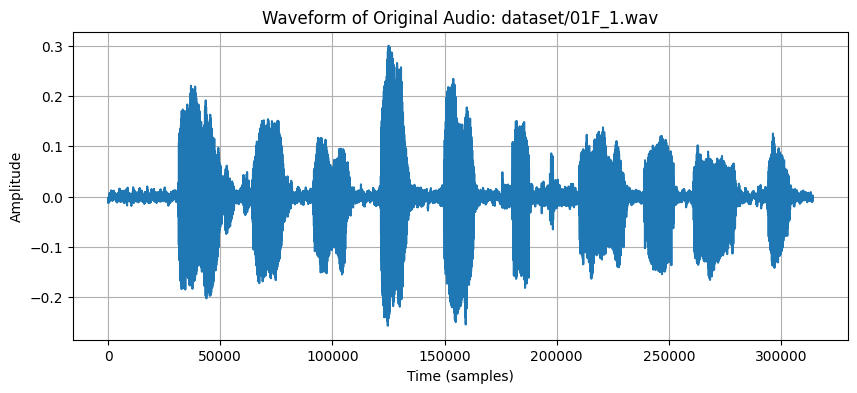

Playing original audio:


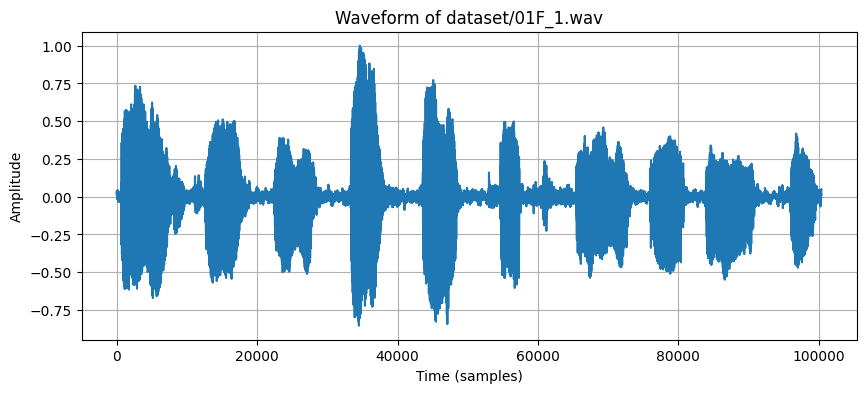

Playing preprocessed audio:


In [61]:
# Plot the waveform of original audio
original_audio = "dataset/01F_1.wav"
orig_signal, sr = librosa.load(original_audio, sr=None)

plt.figure(figsize=(10, 4))
plt.plot(orig_signal)
plt.title(f"Waveform of Original Audio: {original_audio}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

print("Playing original audio:")
display(Audio(orig_signal, rate=sr))

print("=================================================================================================================================================================================")
# Plot the waveform of preprocessed audio

sample_data = audio_data_with_transcripts[0]

signal = sample_data['signal']
sr = sample_data['sampling_rate']
file_path = sample_data['file_path']

plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title(f"Waveform of {file_path}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

print("Playing preprocessed audio:")
display(Audio(signal, rate=sr))

Extract Mel Spectrograms


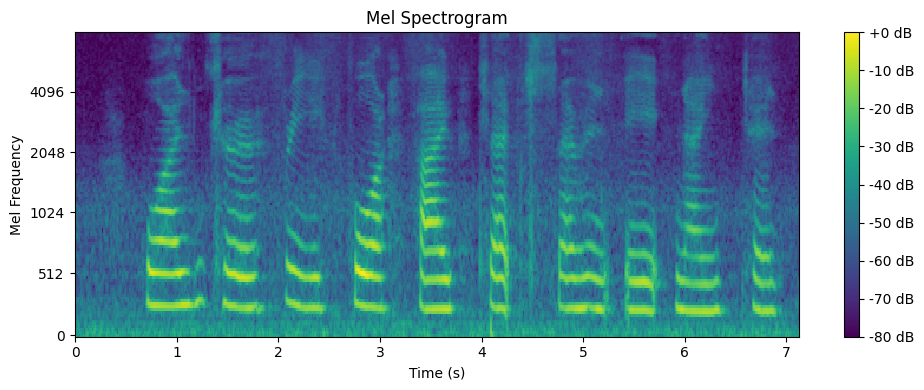

In [62]:

sample_audio = audio_data_with_transcripts[0]
y, sr = librosa.load(sample_audio['file_path'], sr=None)

mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
plt.colorbar(format='%+2.0f dB')  # Add a color bar for amplitude
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()


Build The Model

In [63]:
model = "facebook/wav2vec2-base-960h"
asr_processor = Wav2Vec2Processor.from_pretrained(model)
asr_model = TFWav2Vec2Model.from_pretrained(model)




TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFWav2Vec2Model were not initialized from the PyTorch model and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

Convert Dataset into Tensorflow Dataset

In [75]:
def convert_dataset_to_tf(audio_data_with_transcripts, processor, max_signal_length, test_size=0.3):
    signals = []
    labels = []
    
    # Process the data
    for data in audio_data_with_transcripts:
        try:
            # Extract signal and transcript
            signal = data["signal"]
            transcript = data["transcript"]
            
            # Tokenize transcript to integer IDs
            label = processor.tokenizer(
                transcript, return_tensors="np", padding=True
            ).input_ids[0]
            
            # Pad or truncate signal to max length if specified
            if max_signal_length:
                if len(signal) > max_signal_length:
                    signal = signal[:max_signal_length]  # Truncate
                else:
                    signal = np.pad(signal, (0, max_signal_length - len(signal)), constant_values=0)  # Pad
            
            # Append signal and label
            signals.append(signal)
            labels.append(label)
        
        except KeyError as ke:
            print(f"Missing key in data entry: {ke}")
        except Exception as e:
            print(f"Error processing entry: {e}")
    
    # Convert to NumPy arrays for train-test splitting
    signals = np.array(signals, dtype=np.float32)
    labels = tf.keras.preprocessing.sequence.pad_sequences(
    labels, padding="post", value=processor.tokenizer.pad_token_id, maxlen=430)

    
    # Split the dataset into training and validation (test) sets
    X_train, X_val, y_train, y_val = train_test_split(signals, labels, test_size=test_size, random_state=42)
    
    # Convert them to tf.data.Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    
    return train_dataset, val_dataset


In [76]:
# Get the maximum signal length
max_signal_length = max([len(entry["signal"]) for entry in audio_data_with_transcripts])

# Convert the dataset into TensorFlow datasets for training and validation
train_dataset, val_dataset = convert_dataset_to_tf(audio_data_with_transcripts, asr_processor, max_signal_length)

# Set the batch size
batch_size = 32

# For the training dataset, batch and prefetch it
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# For the validation dataset, batch and prefetch it
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [94]:
asr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    kernel_initializer=tf.keras.initializers.HeNormal()
)

asr_model.summary()


Model: "tf_wav2_vec2_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wav2vec2 (TFWav2Vec2MainLa  multiple                  94371712  
 yer)                                                            
                                                                 
Total params: 94371712 (360.00 MB)
Trainable params: 94371712 (360.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the Model

In [95]:
# Make sure the entire model or specific layers are trainable
for layer in asr_model.layers:
    layer.trainable = True  # Set this for specific layers or the entire model
    

In [96]:
history = asr_model.fit(
    train_dataset,                   
    validation_data=val_dataset,      
    epochs=10,                       
    verbose=1                         
)

Epoch 1/10
1/1 [==============================] - 37s 37s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_categorical_accuracy: 0.9535
Epoch 2/10
1/1 [==============================] - 13s 13s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_categorical_accuracy: 0.9535
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_categorical_accuracy: 0.9535
Epoch 4/10
1/1 [==============================] - 12s 12s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_categorical_accuracy: 0.9535
Epoch 5/10
1/1 [==============================] - 12s 12s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_categorical_accuracy: 0.9535
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: nan - sparse_categorical_accuracy: 0.9930 - val_loss: nan - val_sparse_cat

Training Results

Visualization of Results using MatPlotLib

Save the model

More evaluation 